torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


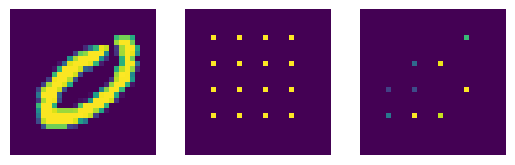

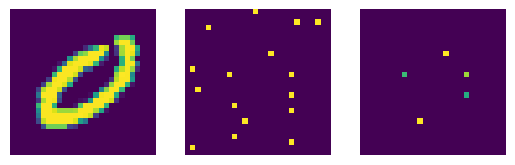

In [5]:
import torch
from config import load_config
from models import Models
from datasets import load_dataset
from plotting import plot_conditioned_examples

config = load_config("VAE")

# Load dataset
train_loader, val_loader, test_loader = load_dataset(config["data_params"])

x, x_cond, y = next(iter(train_loader))
